In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


In [2]:
ls

 cotacaotreino_win_dol.xlsx
 cotacaovalidacao_win_dol.xlsx
 _cotacoes_completa_diario.xlsx
 download_cotacao_allfeatures_diario.ipynb
'LSTM com windfut.ipynb'
 LSTM.ipynb
 strategy01.ipynb
 _validacao_cotacoes_completa_diario.xlsx


In [4]:
data = pd.read_excel('cotacaotreino_win_dol.xlsx')

In [5]:
data

,time,open WIN$,high WIN$,low WIN$,close WIN$,volumeWIN$,open DOL$,high DOL$,low DOL$,close DOL$,volumeDOL$
0,2016-12-21 13:25:00,70695,70852,70689,70815,8192,3829.959,3831.106,3829.959,3831.106,645
1,2016-12-21 13:30:00,70815,70815,70477,70544,22378,3831.106,3832.252,3830.532,3831.106,1160
2,2016-12-21 13:35:00,70538,70664,70501,70622,8733,3831.106,3831.106,3829.959,3830.532,860
3,2016-12-21 13:40:00,70628,70664,70520,70556,6383,3831.106,3831.106,3828.239,3828.812,885
4,2016-12-21 13:45:00,70556,70652,70532,70592,5014,3829.386,3831.106,3829.386,3831.106,1295
...,...,...,...,...,...,...,...,...,...,...,...
89243,2020-04-30 17:30:00,80265,80310,80160,80275,50402,5490.635,5495.143,5488.130,5492.138,785
89244,2020-04-30 17:35:00,80270,80345,80205,80315,40176,5491.136,5493.641,5486.628,5492.639,600
89245,2020-04-30 17:40:00,80310,80340,80165,80180,35605,5492.639,5499.151,5490.134,5494.142,2340
89246,2020-04-30 17:45:00,80180,80245,80095,80140,37704,5493.140,5500.153,5467.092,5498.650,3415


In [9]:
filter_col = [col for col in data if col.startswith('close')]
dados = data[filter_col]


In [10]:
dados

,close WIN$,close DOL$
0,70815,3831.106
1,70544,3831.106
2,70622,3830.532
3,70556,3828.812
4,70592,3831.106
...,...,...
89243,80275,5492.138
89244,80315,5492.639
89245,80180,5494.142
89246,80140,5498.650


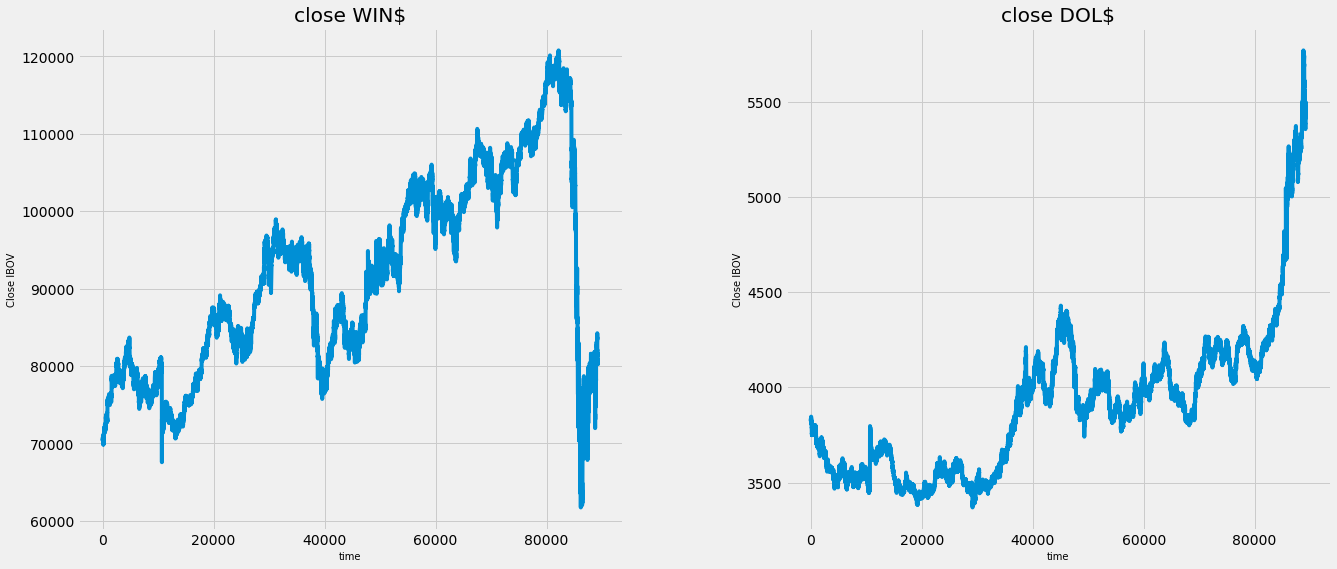

In [15]:
plt.figure(figsize=(20,25))
matplotlib.pyplot.subplots_adjust(wspace=.3, hspace=.9)


for i in range(0,len(dados.columns)):
    plt.subplot(2, 2,i+1)
    plt.plot(dados[dados.columns[i]].values)
    plt.title(dados.columns[i])
    plt.xlabel('time',fontsize=10)
    plt.ylabel('Close IBOV',fontsize=10)

plt.show()

In [16]:
indice = dados.filter(['close WIN$'])

In [17]:
dataset = indice.values
#math.ceil só ta dando um round
len_training_data = math.ceil(len(dataset)*.8)

In [18]:
#scale the data
scaler = MinMaxScaler(feature_range=(0,1)) #escala de 0 a 1 
scaled_data = scaler.fit_transform(dataset)

In [19]:
#split
train_data = scaled_data[:len_training_data]
len(train_data)

71399

In [20]:
x_train, y_train = [],[]
for i in range(30,len(train_data)):
#     x_train.append(train_data[i-30:i])
    x_train.append(train_data[i-30:i,0])
#     y_train.append(train_data[i,0])
    y_train.append(train_data[i,0]) #proximo termo 



In [21]:
x_train, y_train = np.array(x_train), np.array(y_train)


In [22]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [23]:
#creating the lstm model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [24]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
10624/71369 [===>..........................] - ETA: 1:06:44 - loss: 2.2992e-04

In [215]:
test_data = scaled_data[len_training_data - 30 : , :]

In [217]:
x_test, y_test = [], dataset[len_training_data : , :]
for i in range(30,len(test_data)):
#     x_train.append(train_data[i-30:i])
    x_test.append(train_data[i-30:i,0])


In [218]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [219]:
prediction = model.predict(x_test)

In [221]:
prediction = scaler.inverse_transform(prediction)

In [224]:
rmse = np.sqrt(np.mean(((prediction - y_test)**2)))
rmse

889.7995900685436

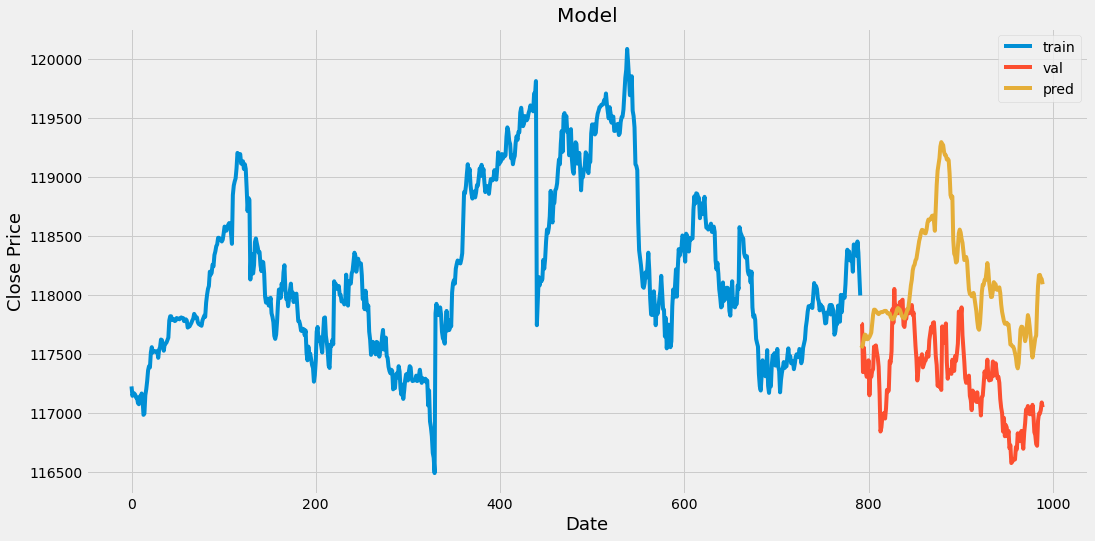

In [239]:
train = data[:len_training_data]
valid = data[len_training_data:].copy()

valid['Predictions'] = prediction
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close IND$'])
plt.plot(valid[['Close IND$', 'Predictions']])
plt.legend(['train','val','pred'])
plt.show()

In [13]:
data = data[['Close IND$','Close DOL$']].copy()
data.head()

,Close IND$,Close DOL$
0,117226,4104.025
1,117146,4102.511
2,117171,4102.007
3,117166,4096.456
4,117156,4087.373


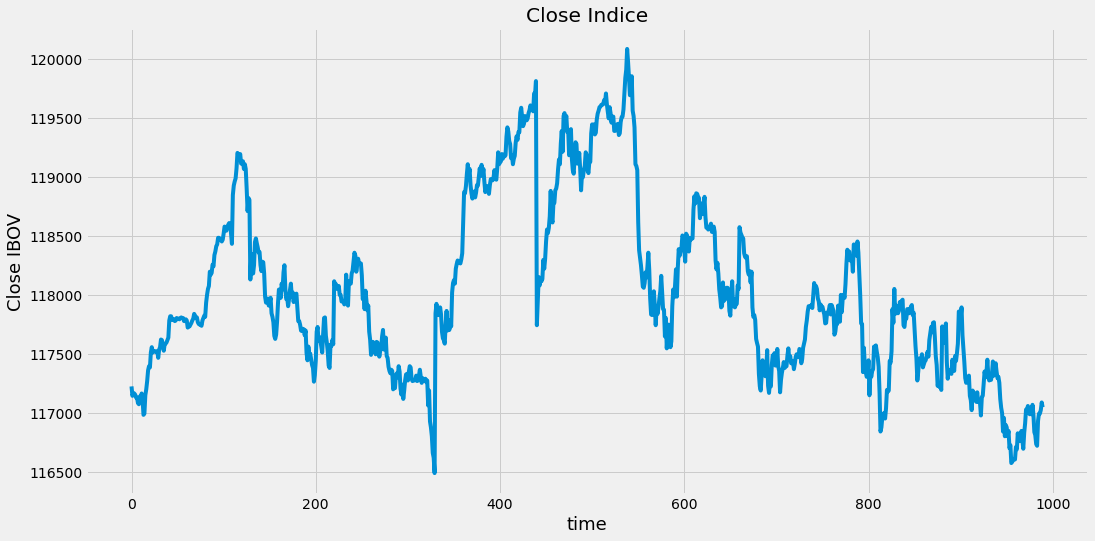

In [18]:
plt.figure(figsize=(16,8))
plt.title('Close Indice')
plt.plot(data['Close IND$'])
plt.xlabel('time',fontsize=18)
plt.ylabel('Close IBOV',fontsize=18)
plt.show()

In [20]:
data.columns

Index(['Close IND$', 'Close DOL$'], dtype='object')